In [79]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.utils import resample
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Flatten,SimpleRNN
import pandas as pd
from ctgan import CTGAN
from tensorflow.keras.models import Model
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, classification_report, confusion_matrix


from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense



In [2]:
# Dataset Path
data_path = 'D:/NCI/Sem 3/Thesis/code_DB/dataset'

In [3]:
#classes
class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

# Initialize lists to hold features and labels
X = []
y = []

# Parameters for feature extraction
n_mfcc = 13  # Number of MFCC features to extract
n_chroma = 12  # Number of chroma features
n_spectral_contrast = 7  # Number of spectral contrast features
max_pad_len = 174  # Ensure all audio files have the same length


In [4]:
results_df = pd.DataFrame(columns=['Model', 'Accuracy','F1 Score','Precision','Recall'])

In [5]:
def extract_mfcc(file_path):
    """Extract MFCC features from a given audio file."""
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    # Pad or truncate the MFCCs to a fixed length
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    return mfccs

In [6]:
# Loop through each class folder and extract MFCCs
for i, label in enumerate(class_labels):
    folder_path = os.path.join(data_path, label)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            mfcc = extract_mfcc(file_path)
            X.append(mfcc)
            y.append(i)  # Store the class label as an integer

In [7]:
# Convert to numpy arrays
X_mfcc = np.array(X)
y_mfcc = np.array(y)
X1 = X_mfcc
y1 = y_mfcc

In [8]:
# Reshape X to be suitable for the SVM
X_mfcc = X_mfcc.reshape(X_mfcc.shape[0], -1)  # Flatten the MFCC array

In [9]:
print(f'Extracted {X_mfcc.shape[0]} samples with shape {X_mfcc.shape}')

Extracted 457 samples with shape (457, 2262)


## Simple models with original data

In [10]:
#Split the data into training and test sets
X_mfcc_train, X_mfcc_test, y_mfcc_train, y_mfcc_test = train_test_split(X_mfcc, y_mfcc, test_size=0.2, random_state=42)

1. SVM model Simple

In [11]:
# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

In [12]:
# Define a list of scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}



In [13]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(svm_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [14]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["SVM (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
print(results_df)



5-Fold Cross-Validation Accuracy: 0.77
5-Fold Cross-Validation F1_weighted: 0.75
5-Fold Cross-Validation Precision_weighted: 0.73
5-Fold Cross-Validation Recall_weighted: 0.77
             Model  Accuracy  F1 Score  Precision    Recall
0  SVM (5-fold CV)  0.767123  0.748734   0.731613  0.767123


In [15]:
# Refit the model with the training data for confusion matrix and report
svm_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = svm_model.predict(X_mfcc_test)

# Print classification report
#class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']  #  class names
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))




              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.25      0.14      0.18         7
      hungry       0.81      0.85      0.83        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.67        92
   macro avg       0.21      0.20      0.20        92
weighted avg       0.66      0.67      0.66        92



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

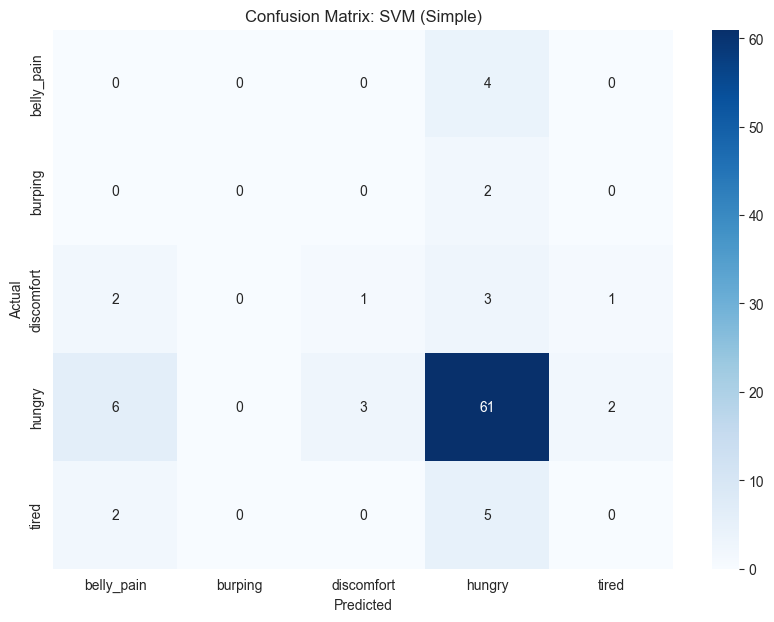

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: SVM (Simple)')
plt.show()

2. KNN-Simple

In [17]:
# Step 1: Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors based on your analysis

# Step 2: Define scoring metrics for cross-validation
'''scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted')
}'''

# Step 3: Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(knn_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

# Step 4: Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["KNN (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
print(results_df)

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

5-Fold Cross-Validation Accuracy: 0.84
5-Fold Cross-Validation F1_weighted: 0.77
5-Fold Cross-Validation Precision_weighted: 0.72
5-Fold Cross-Validation Recall_weighted: 0.84
             Model  Accuracy  F1 Score  Precision    Recall
0  SVM (5-fold CV)  0.767123  0.748734   0.731613  0.767123
1  KNN (5-fold CV)  0.838356  0.774607   0.719904  0.838356


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      0.99      0.87        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.77        92
   macro avg       0.16      0.20      0.17        92
weighted avg       0.61      0.77      0.68        92



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

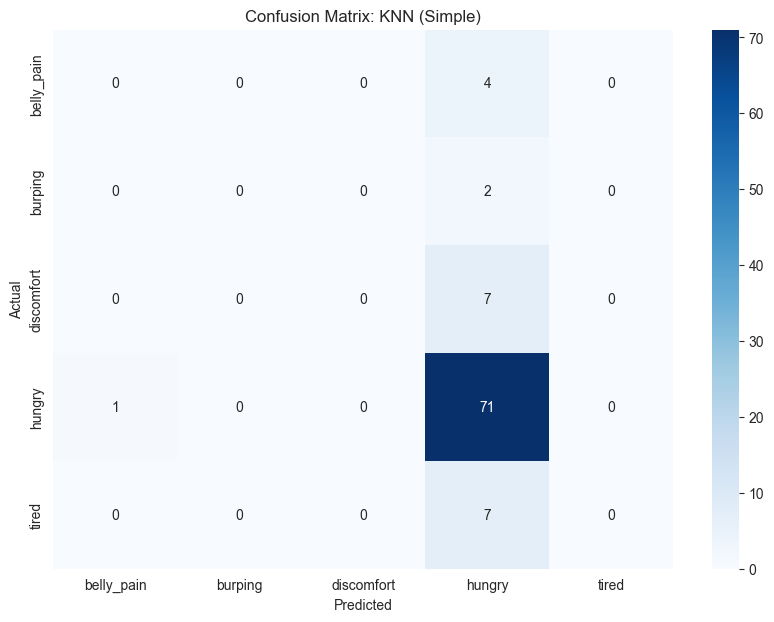

In [18]:
# Refit the model with the training data for confusion matrix and report
knn_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = knn_model.predict(X_mfcc_test)

# Print classification report
#class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']  #  class names
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: KNN (Simple)')
plt.show()

3. Random Forest (Simple)

In [19]:
# Random Forest

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [20]:
# Step 3: Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(rf_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [21]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.85
5-Fold Cross-Validation F1_weighted: 0.78
5-Fold Cross-Validation Precision_weighted: 0.72
5-Fold Cross-Validation Recall_weighted: 0.85


In [22]:
# Step : Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["Random Forest (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
print(results_df)

                       Model  Accuracy  F1 Score  Precision    Recall
0            SVM (5-fold CV)  0.767123  0.748734   0.731613  0.767123
1            KNN (5-fold CV)  0.838356  0.774607   0.719904  0.838356
2  Random Forest (5-fold CV)  0.849315  0.780112   0.721336  0.849315


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      1.00      0.88        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.78        92
   macro avg       0.16      0.20      0.18        92
weighted avg       0.61      0.78      0.69        92



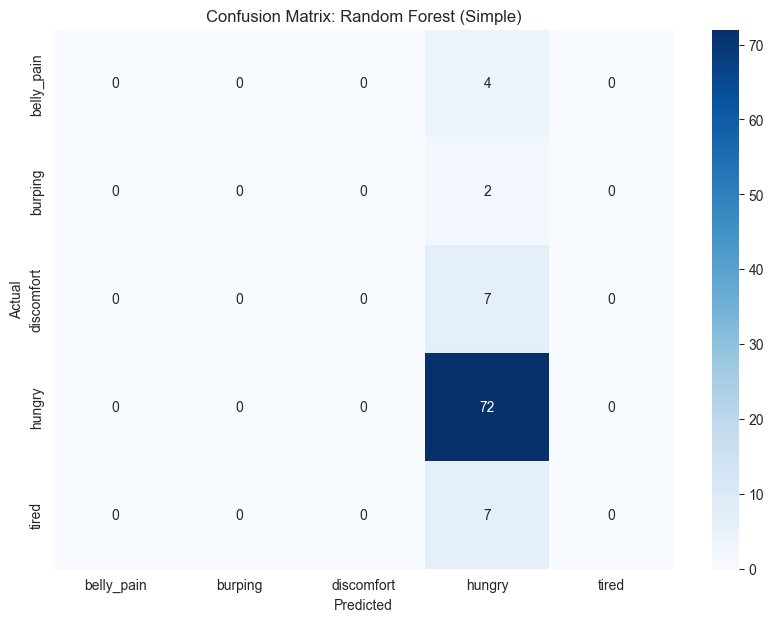

In [23]:
# Refit the model with the training data for confusion matrix and report
rf_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = rf_model.predict(X_mfcc_test)

# Print classification report
#class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']  #  class names
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Random Forest (Simple)')
plt.show()

4. AdaBoost model

In [24]:
# Initializing the AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

In [25]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(ada_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [26]:
# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

5-Fold Cross-Validation Accuracy: 0.76
5-Fold Cross-Validation F1_weighted: 0.74
5-Fold Cross-Validation Precision_weighted: 0.74
5-Fold Cross-Validation Recall_weighted: 0.76


In [27]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["AdaBoost (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
print(results_df)

                       Model  Accuracy  F1 Score  Precision    Recall
0            SVM (5-fold CV)  0.767123  0.748734   0.731613  0.767123
1            KNN (5-fold CV)  0.838356  0.774607   0.719904  0.838356
2  Random Forest (5-fold CV)  0.849315  0.780112   0.721336  0.849315
3       AdaBoost (5-fold CV)  0.758904  0.736453   0.738580  0.758904


In [28]:
'''results_df=results_df.iloc[:-1]
results_df #delete last row'''

'results_df=results_df.iloc[:-1]\nresults_df #delete last row'

In [29]:
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      0.96      0.86        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.75        92
   macro avg       0.16      0.19      0.17        92
weighted avg       0.61      0.75      0.68        92



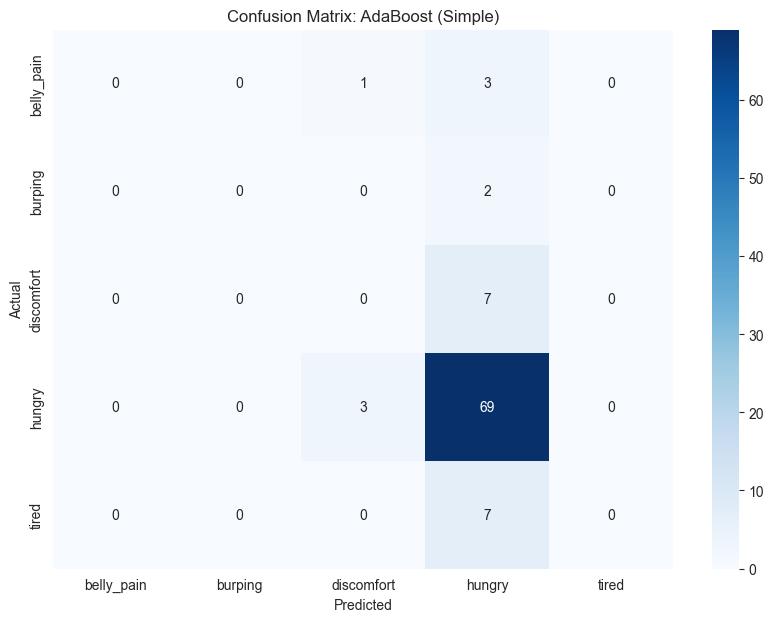

In [30]:
# Refit the model with the training data for confusion matrix and report
ada_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = ada_model.predict(X_mfcc_test)

# Print classification report
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: AdaBoost (Simple)')
plt.show()

5. XGBoost Model

In [31]:
# Initializing the XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

In [32]:
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(xgb_model, X_mfcc_train, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()

# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:03:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Par

5-Fold Cross-Validation Accuracy: 0.84
5-Fold Cross-Validation F1_weighted: 0.78
5-Fold Cross-Validation Precision_weighted: 0.72
5-Fold Cross-Validation Recall_weighted: 0.84


In [33]:
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["XGBoost (5-fold CV)", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
print(results_df)

                       Model  Accuracy  F1 Score  Precision    Recall
0            SVM (5-fold CV)  0.767123  0.748734   0.731613  0.767123
1            KNN (5-fold CV)  0.838356  0.774607   0.719904  0.838356
2  Random Forest (5-fold CV)  0.849315  0.780112   0.721336  0.849315
3       AdaBoost (5-fold CV)  0.758904  0.736453   0.738580  0.758904
4        XGBoost (5-fold CV)  0.843836  0.777370   0.720625  0.843836


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [14:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         4
     burping       0.00      0.00      0.00         2
  discomfort       0.00      0.00      0.00         7
      hungry       0.78      1.00      0.88        72
       tired       0.00      0.00      0.00         7

    accuracy                           0.78        92
   macro avg       0.16      0.20      0.18        92
weighted avg       0.61      0.78      0.69        92



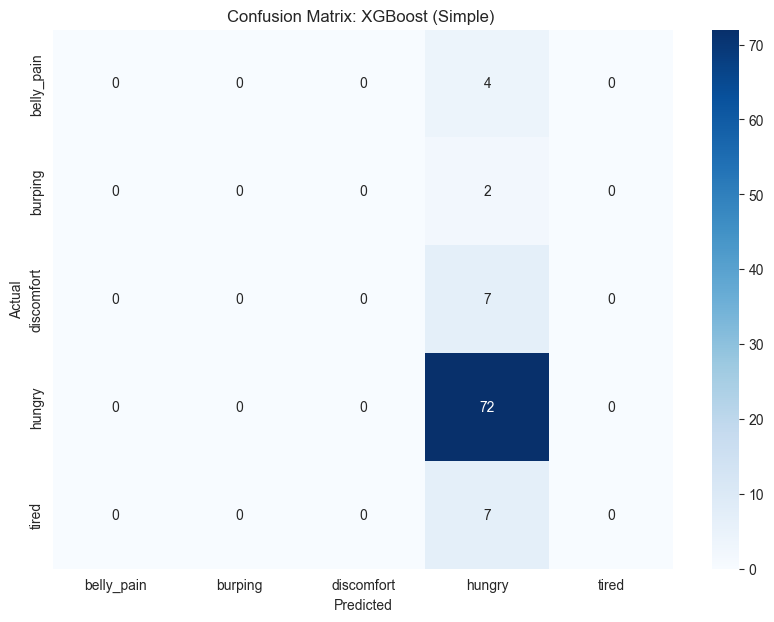

In [34]:
# Refit the model with the training data for confusion matrix and report
xgb_model.fit(X_mfcc_train, y_mfcc_train)
y_pred_svm = xgb_model.predict(X_mfcc_test)

# Print classification report
#class_labels = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']  #  class names
print(classification_report(y_mfcc_test, y_pred_svm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_svm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: XGBoost (Simple) ')
plt.show()


6. LSTM

In [35]:
# Reshape X for LSTM (samples, time_steps, features)
X_lstm = X1.reshape(X1.shape[0], X1.shape[2], X1.shape[1])  # (samples, time_steps, features)


In [36]:
# One-hot encode labels
y_lstm = to_categorical(y1, num_classes=len(class_labels))

In [37]:
y_lstm.shape

(457, 5)

In [38]:
# Split the data into train and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42, stratify=y1)

In [39]:
y_test_lstm.shape

(138, 5)

In [40]:
y_train_lstm.shape

(319, 5)

In [41]:
# Define the LSTM model
lstm_model = Sequential()
# Add LSTM layer
lstm_model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.3))
# Add another LSTM layer
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.3))
# Add Dense layers
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.3))
# Output layer with softmax for multi-class classification
lstm_model.add(Dense(len(class_labels), activation='softmax'))
# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/50
10/10 [==============================] - 22s 1s/step - loss: 1.1815 - accuracy: 0.6426 - val_loss: 0.7331 - val_accuracy: 0.8333
Epoch 2/50
10/10 [==============================] - 5s 451ms/step - loss: 0.7880 - accuracy: 0.8307 - val_loss: 0.7026 - val_accuracy: 0.8333
Epoch 3/50
10/10 [==============================] - 4s 426ms/step - loss: 0.7573 - accuracy: 0.8370 - val_loss: 0.6778 - val_accuracy: 0.8333
Epoch 4/50
10/10 [==============================] - 6s 644ms/step - loss: 0.7049 - accuracy: 0.8370 - val_loss: 0.6769 - val_accuracy: 0.8333
Epoch 5/50
10/10 [==============================] - 6s 596ms/step - loss: 0.7082 - accuracy: 0.8370 - val_loss: 0.6747 - val_accuracy: 0.8333
Epoch 6/50
10/10 [==============================] - 5s 505ms/step - loss: 0.7051 - accuracy: 0.8339 - val_loss: 0.6749 - val_accuracy: 0.8333
Epoch 7/50
10/10 [==============================] - 4s 421ms/step - loss: 0.6731 - accuracy: 0.8370 - val_loss: 0.6737 - val_accuracy: 0.8333
Epoch 8/

In [42]:
# Evaluate the model
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_test_lstm_ = np.argmax(y_test_lstm, axis=1)

5/5 [==============================] - 3s 94ms/step


In [43]:
# Accuracy
accuracy = accuracy_score(y_test_lstm_, y_pred_lstm)
f1 = f1_score(y_test_lstm_, y_pred_lstm, average='weighted')
precision = precision_score(y_test_lstm_, y_pred_lstm, average='weighted')
recall = recall_score(y_test_lstm_, y_pred_lstm, average='weighted')

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
new_row_cv = pd.DataFrame([["LSTM", accuracy , f1, precision,recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
'''
new_row_cv = pd.DataFrame([["LSTM", results['accuracy'], results['f1_weighted'], 
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])'''
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
print(results_df)

                       Model  Accuracy  F1 Score  Precision    Recall
0            SVM (5-fold CV)  0.767123  0.748734   0.731613  0.767123
1            KNN (5-fold CV)  0.838356  0.774607   0.719904  0.838356
2  Random Forest (5-fold CV)  0.849315  0.780112   0.721336  0.849315
3       AdaBoost (5-fold CV)  0.758904  0.736453   0.738580  0.758904
4        XGBoost (5-fold CV)  0.843836  0.777370   0.720625  0.843836
5                       LSTM  0.775362  0.730874   0.691214  0.775362


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         5
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         8
      hungry       0.83      0.93      0.88       115
       tired       0.00      0.00      0.00         7

    accuracy                           0.78       138
   macro avg       0.17      0.19      0.18       138
weighted avg       0.69      0.78      0.73       138



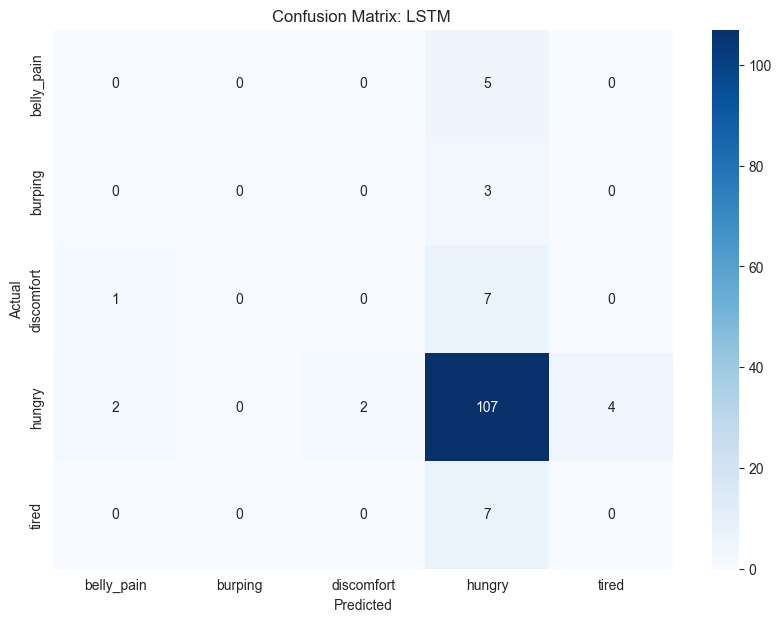

In [45]:
# Classification report
print(classification_report(y_test_lstm_, y_pred_lstm, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_lstm_, y_pred_lstm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: LSTM ')
plt.show()

6. RNN

In [46]:
# Split the data into train and test sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42, stratify=y1)

In [47]:
# Define the RNN model
rnn_model = Sequential()

In [48]:
# Add SimpleRNN layer
rnn_model.add(SimpleRNN(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
rnn_model.add(Dropout(0.3))

In [49]:
# Add another SimpleRNN layer
rnn_model.add(SimpleRNN(64, return_sequences=False))
rnn_model.add(Dropout(0.3))



In [50]:
# Add Dense layers
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dropout(0.3))
# Output layer with softmax for multi-class classification
rnn_model.add(Dense(len(class_labels), activation='softmax'))
# Compile the model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [51]:
# Train the model
history = rnn_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/50
10/10 [==============================] - 8s 236ms/step - loss: 1.7434 - accuracy: 0.2132 - val_loss: 1.2182 - val_accuracy: 0.5507
Epoch 2/50
10/10 [==============================] - 2s 164ms/step - loss: 1.3365 - accuracy: 0.5110 - val_loss: 1.0350 - val_accuracy: 0.6449
Epoch 3/50
10/10 [==============================] - 2s 162ms/step - loss: 1.0741 - accuracy: 0.6458 - val_loss: 0.9204 - val_accuracy: 0.7609
Epoch 4/50
10/10 [==============================] - 2s 158ms/step - loss: 1.0377 - accuracy: 0.6740 - val_loss: 0.8659 - val_accuracy: 0.7971
Epoch 5/50
10/10 [==============================] - 2s 159ms/step - loss: 0.9014 - accuracy: 0.7555 - val_loss: 0.8356 - val_accuracy: 0.8043
Epoch 6/50
10/10 [==============================] - 2s 168ms/step - loss: 0.8589 - accuracy: 0.7555 - val_loss: 0.8119 - val_accuracy: 0.8116
Epoch 7/50
10/10 [==============================] - 2s 164ms/step - loss: 0.7728 - accuracy: 0.7743 - val_loss: 0.7972 - val_accuracy: 0.8333
Epoch 

In [52]:
# Evaluate the model
y_pred_rnn = np.argmax(rnn_model.predict(X_test_lstm), axis=1)
y_test_rnn = np.argmax(y_test_lstm, axis=1)


5/5 [==============================] - 1s 39ms/step


In [53]:
# Accuracy
accuracy = accuracy_score(y_test_rnn, y_pred_rnn)
f1 = f1_score(y_test_rnn, y_pred_rnn, average='weighted')
precision = precision_score(y_test_rnn, y_pred_rnn, average='weighted')
recall = recall_score(y_test_rnn, y_pred_rnn, average='weighted')


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:

new_row_cv = pd.DataFrame([["RNN", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
print(results_df)


                       Model  Accuracy  F1 Score  Precision    Recall
0            SVM (5-fold CV)  0.767123  0.748734   0.731613  0.767123
1            KNN (5-fold CV)  0.838356  0.774607   0.719904  0.838356
2  Random Forest (5-fold CV)  0.849315  0.780112   0.721336  0.849315
3       AdaBoost (5-fold CV)  0.758904  0.736453   0.738580  0.758904
4        XGBoost (5-fold CV)  0.843836  0.777370   0.720625  0.843836
5                       LSTM  0.775362  0.730874   0.691214  0.775362
6                        RNN  0.818841  0.750332   0.692402  0.818841


              precision    recall  f1-score   support

  belly_pain       0.00      0.00      0.00         5
     burping       0.00      0.00      0.00         3
  discomfort       0.00      0.00      0.00         8
      hungry       0.83      0.98      0.90       115
       tired       0.00      0.00      0.00         7

    accuracy                           0.82       138
   macro avg       0.17      0.20      0.18       138
weighted avg       0.69      0.82      0.75       138



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

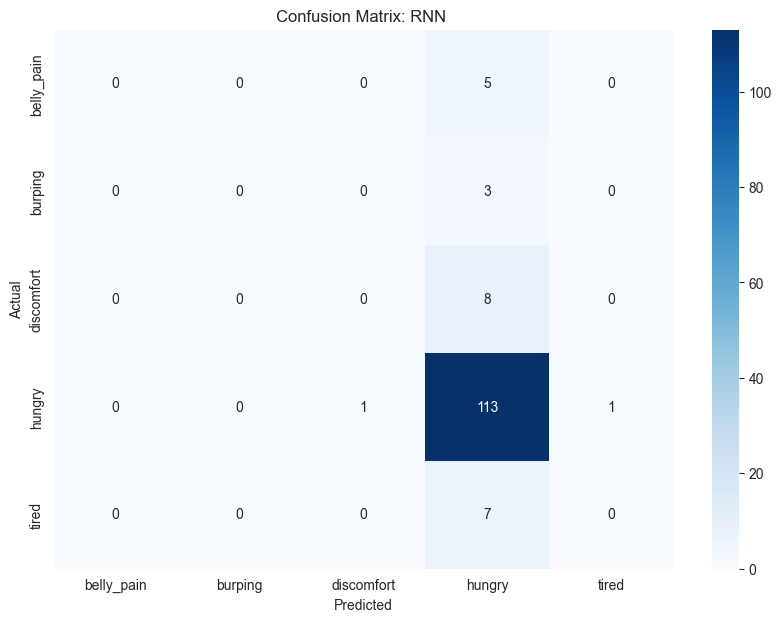

In [55]:
# Classification report
print(classification_report(y_test_rnn, y_pred_rnn, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_rnn, y_pred_rnn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: RNN ')
plt.show()

8. CNN

In [56]:
timesteps = 6  # Use 2, 3, or 6 based on preference and experiment
n_features = X_mfcc_train.shape[1] // timesteps  # Adjust n_features

# Reshaping data for CNN
X_mfcc_train_cnn = X_mfcc_train.reshape((X_mfcc_train.shape[0], timesteps, n_features))
X_mfcc_test_cnn = X_mfcc_test.reshape((X_mfcc_test.shape[0], timesteps, n_features))

# Check the shapes
print("Training data shape:", X_mfcc_train_cnn.shape)
print("Testing data shape:", X_mfcc_test_cnn.shape)

Training data shape: (365, 6, 377)
Testing data shape: (92, 6, 377)


In [57]:
# One-hot encode labels
num_classes = len(np.unique(y_mfcc_train))
y_train_cnn = to_categorical(y_mfcc_train, num_classes)
y_test_cnn = to_categorical(y_mfcc_test, num_classes)



In [58]:
# CNN Model
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))




In [59]:
# Compile and Train the Model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_mfcc_train_cnn, y_train_cnn, epochs=20, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/20
10/10 - 2s - loss: 153.5426 - accuracy: 0.6884 - val_loss: 132.6333 - val_accuracy: 0.8082 - 2s/epoch - 192ms/step
Epoch 2/20
10/10 - 0s - loss: 67.8305 - accuracy: 0.7637 - val_loss: 65.7020 - val_accuracy: 0.8082 - 110ms/epoch - 11ms/step
Epoch 3/20
10/10 - 0s - loss: 43.4328 - accuracy: 0.7432 - val_loss: 33.6186 - val_accuracy: 0.7945 - 110ms/epoch - 11ms/step
Epoch 4/20
10/10 - 0s - loss: 22.5539 - accuracy: 0.6986 - val_loss: 26.9348 - val_accuracy: 0.8082 - 110ms/epoch - 11ms/step
Epoch 5/20
10/10 - 0s - loss: 16.0796 - accuracy: 0.7774 - val_loss: 17.9869 - val_accuracy: 0.7945 - 110ms/epoch - 11ms/step
Epoch 6/20
10/10 - 0s - loss: 11.2626 - accuracy: 0.7500 - val_loss: 10.8192 - val_accuracy: 0.8082 - 110ms/epoch - 11ms/step
Epoch 7/20
10/10 - 0s - loss: 8.3849 - accuracy: 0.7500 - val_loss: 13.1681 - val_accuracy: 0.8082 - 110ms/epoch - 11ms/step
Epoch 8/20
10/10 - 0s - loss: 5.1865 - accuracy: 0.8082 - val_loss: 9.8407 - val_accuracy: 0.7671 - 110ms/epoch - 11ms/

In [60]:
# Make predictions on the test data
y_pred_cnn = cnn_model.predict(X_mfcc_test_cnn)
# Convert predictions and true labels from one-hot encoded format to class labels
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_true_classes_cnn = np.argmax(y_test_cnn, axis=1)


3/3 [==============================] - 0s 0s/step


In [61]:
# Generate a classification report
print(classification_report(y_true_classes_cnn, y_pred_classes_cnn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         7
           3       0.77      0.94      0.85        72
           4       0.00      0.00      0.00         7

    accuracy                           0.74        92
   macro avg       0.15      0.19      0.17        92
weighted avg       0.60      0.74      0.67        92



D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

In [62]:
# Accuracy
accuracy = accuracy_score(y_true_classes_cnn, y_pred_classes_cnn)

# F1 Score
f1 = f1_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

# Precision
precision = precision_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

# Recall
recall = recall_score(y_true_classes_cnn, y_pred_classes_cnn, average='weighted')

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
new_row_cv = pd.DataFrame([["CNN", accuracy , f1, precision,recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
print(results_df)

                       Model  Accuracy  F1 Score  Precision    Recall
0            SVM (5-fold CV)  0.767123  0.748734   0.731613  0.767123
1            KNN (5-fold CV)  0.838356  0.774607   0.719904  0.838356
2  Random Forest (5-fold CV)  0.849315  0.780112   0.721336  0.849315
3       AdaBoost (5-fold CV)  0.758904  0.736453   0.738580  0.758904
4        XGBoost (5-fold CV)  0.843836  0.777370   0.720625  0.843836
5                       LSTM  0.775362  0.730874   0.691214  0.775362
6                        RNN  0.818841  0.750332   0.692402  0.818841
7                        CNN  0.739130  0.665217   0.604743  0.739130


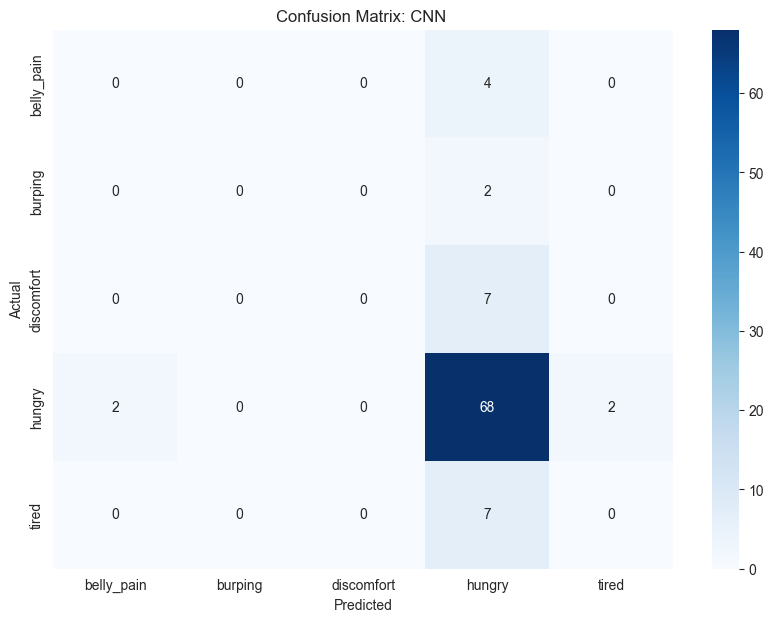

In [64]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes_cnn, y_pred_classes_cnn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CNN ')
plt.show()

9. CNN-XGBoost

In [65]:
# Define the CNN model up to the Flatten layer
cnn_xg_model = Sequential()
cnn_xg_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_xg_model.add(MaxPooling1D(pool_size=2))
cnn_xg_model.add(Flatten())  # Feature extraction layer
cnn_xg_model.add(Dropout(0.5))

# Convert to a feature-extractor model that stops at the Flatten layer
feature_extractor = Model(inputs=cnn_xg_model.input, outputs=cnn_xg_model.layers[-2].output)

In [66]:
# Extract features from training and test data
X_train_features = feature_extractor.predict(X_mfcc_train_cnn)
X_test_features = feature_extractor.predict(X_mfcc_test_cnn)


3/3 [==============================] - 0s 3ms/step


In [67]:
'''# Initializing the XGBoost model
xgb_model_1 = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
# Apply 5-fold cross-validation and collect each metric's results
results = {}
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(xgb_model_1, X_train_features, y_mfcc_train, cv=5, scoring=metric)
    results[metric_name] = scores.mean()
'''


"# Initializing the XGBoost model\nxgb_model_1 = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)\n# Apply 5-fold cross-validation and collect each metric's results\nresults = {}\nfor metric_name, metric in scoring_metrics.items():\n    scores = cross_val_score(xgb_model_1, X_train_features, y_mfcc_train, cv=5, scoring=metric)\n    results[metric_name] = scores.mean()\n"

In [68]:
'''# Print the average cross-validation results for each metric
for metric_name, score in results.items():
    print(f'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}')
# Add the cross-validation results to the results dataframe
new_row_cv = pd.DataFrame([["CNN-XGBoost (5-fold CV)", results['accuracy'], results['f1_weighted'],
                            results['precision_weighted'], results['recall_weighted']]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
print(results_df)'''

'# Print the average cross-validation results for each metric\nfor metric_name, score in results.items():\n    print(f\'5-Fold Cross-Validation {metric_name.capitalize()}: {score:.2f}\')\n# Add the cross-validation results to the results dataframe\nnew_row_cv = pd.DataFrame([["CNN-XGBoost (5-fold CV)", results[\'accuracy\'], results[\'f1_weighted\'],\n                            results[\'precision_weighted\'], results[\'recall_weighted\']]],\n                          columns=[\'Model\', \'Accuracy\', \'F1 Score\', \'Precision\', \'Recall\'])\nresults_df = pd.concat([results_df, new_row_cv], ignore_index=True)\nprint(results_df)'

In [69]:
# Initialize and train the XGBoost classifier
xgb_cnn_model = XGBClassifier(objective='multi:softmax', num_class=num_classes, eval_metric='mlogloss')
xgb_cnn_model.fit(X_train_features, y_mfcc_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [70]:
# Make predictions with XGBoost
y_pred_xgb_cnn = xgb_cnn_model.predict(X_test_features)

In [71]:
new_row_cv = pd.DataFrame([["CNN-XGBoost", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
print(results_df)


                       Model  Accuracy  F1 Score  Precision    Recall
0            SVM (5-fold CV)  0.767123  0.748734   0.731613  0.767123
1            KNN (5-fold CV)  0.838356  0.774607   0.719904  0.838356
2  Random Forest (5-fold CV)  0.849315  0.780112   0.721336  0.849315
3       AdaBoost (5-fold CV)  0.758904  0.736453   0.738580  0.758904
4        XGBoost (5-fold CV)  0.843836  0.777370   0.720625  0.843836
5                       LSTM  0.775362  0.730874   0.691214  0.775362
6                        RNN  0.818841  0.750332   0.692402  0.818841
7                        CNN  0.739130  0.665217   0.604743  0.739130
8                CNN-XGBoost  0.739130  0.665217   0.604743  0.739130


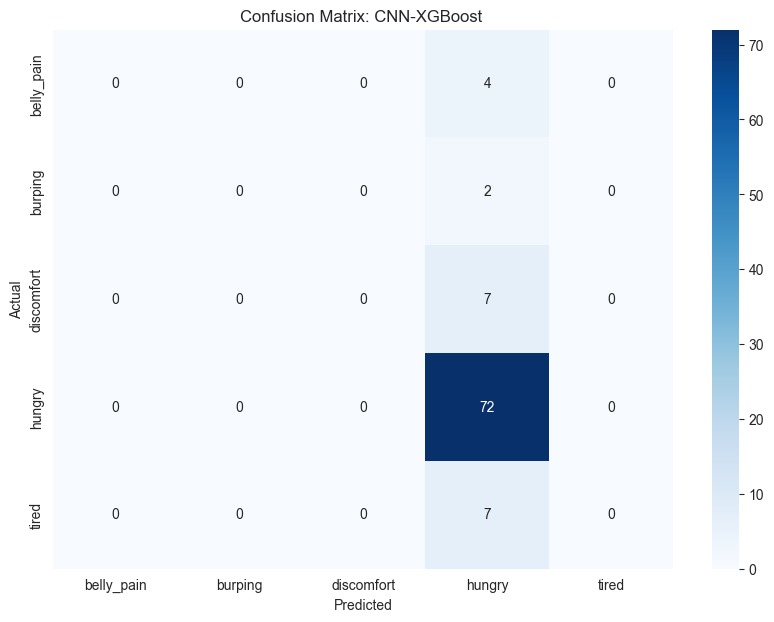

In [72]:
# Confusion Matrix
cm = confusion_matrix(y_mfcc_test, y_pred_xgb_cnn)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: CNN-XGBoost ')
plt.show()

10.CNN-LSTM

In [73]:
# CNN-LSTM Model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(64, activation='relu'))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(Dense(num_classes, activation='softmax'))

In [74]:
# Compile and Train the Model
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_lstm_model.fit(X_mfcc_train_cnn, y_train_cnn, epochs=20, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/20
10/10 - 2s - loss: 16.6110 - accuracy: 0.5479 - val_loss: 6.2412 - val_accuracy: 0.7534 - 2s/epoch - 220ms/step
Epoch 2/20
10/10 - 0s - loss: 5.6268 - accuracy: 0.6438 - val_loss: 2.1757 - val_accuracy: 0.7534 - 125ms/epoch - 13ms/step
Epoch 3/20
10/10 - 0s - loss: 3.6273 - accuracy: 0.5342 - val_loss: 1.6159 - val_accuracy: 0.8219 - 126ms/epoch - 13ms/step
Epoch 4/20
10/10 - 0s - loss: 1.3462 - accuracy: 0.6815 - val_loss: 1.3253 - val_accuracy: 0.7671 - 141ms/epoch - 14ms/step
Epoch 5/20
10/10 - 0s - loss: 1.2241 - accuracy: 0.8014 - val_loss: 1.1355 - val_accuracy: 0.7808 - 94ms/epoch - 9ms/step
Epoch 6/20
10/10 - 0s - loss: 1.0804 - accuracy: 0.8288 - val_loss: 0.9776 - val_accuracy: 0.7671 - 110ms/epoch - 11ms/step
Epoch 7/20
10/10 - 0s - loss: 1.1181 - accuracy: 0.8390 - val_loss: 1.0177 - val_accuracy: 0.7534 - 125ms/epoch - 13ms/step
Epoch 8/20
10/10 - 0s - loss: 1.1339 - accuracy: 0.8082 - val_loss: 0.8800 - val_accuracy: 0.7808 - 110ms/epoch - 11ms/step
Epoch 9/20


In [75]:
# Make predictions on the test data
y_pred_cnn_lstm = cnn_model.predict(X_mfcc_test_cnn)
# Convert predictions and true labels from one-hot encoded format to class labels
y_pred_classes_cnn_lstm = np.argmax(y_pred_cnn_lstm, axis=1)
y_true_classes_cnn_lstm = np.argmax(y_pred_cnn_lstm, axis=1)

# Generate a classification report
print(classification_report(y_true_classes_cnn_lstm, y_pred_classes_cnn_lstm))

3/3 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           3       1.00      1.00      1.00        88
           4       1.00      1.00      1.00         2

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92



In [76]:
# Make predictions on the test data
y_pred_cnn_lstm = cnn_lstm_model.predict(X_mfcc_test_cnn)

# Convert predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred_cnn_lstm, axis=1)
y_true_classes = np.argmax(y_test_cnn, axis=1)


3/3 [==============================] - 0s 8ms/step


In [77]:
# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Precision
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')

# Recall
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.7826
F1 Score: 0.6872
Precision: 0.6125
Recall: 0.7826


D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
new_row_cv = pd.DataFrame([["CNN-LSTM", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
print(results_df)

                       Model  Accuracy  F1 Score  Precision    Recall
0            SVM (5-fold CV)  0.767123  0.748734   0.731613  0.767123
1            KNN (5-fold CV)  0.838356  0.774607   0.719904  0.838356
2  Random Forest (5-fold CV)  0.849315  0.780112   0.721336  0.849315
3       AdaBoost (5-fold CV)  0.758904  0.736453   0.738580  0.758904
4        XGBoost (5-fold CV)  0.843836  0.777370   0.720625  0.843836
5                       LSTM  0.775362  0.730874   0.691214  0.775362
6                        RNN  0.818841  0.750332   0.692402  0.818841
7                        CNN  0.739130  0.665217   0.604743  0.739130
8                CNN-XGBoost  0.739130  0.665217   0.604743  0.739130
9                   CNN-LSTM  0.782609  0.687169   0.612476  0.782609


11.Ensemble learning

In [98]:
timesteps = 1
n_features = X_mfcc_train.shape[1] # Adjust n_features



In [100]:
# Reshaping data for CNN
X_mfcc_train_cnn = X_mfcc_train.reshape((X_mfcc_train.shape[0], timesteps, n_features))
X_mfcc_test_cnn = X_mfcc_test.reshape((X_mfcc_test.shape[0], timesteps, n_features))

# Check the shapes
print("Training data shape:", X_mfcc_train_cnn.shape)
print("Testing data shape:", X_mfcc_test_cnn.shape)



Training data shape: (365, 1, 2262)
Testing data shape: (92, 1, 2262)


In [101]:
# Check the shapes
print("Training data shape:", X_mfcc_train_cnn.shape)
print("Testing data shape:", X_mfcc_test_cnn.shape)
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical if they are not already
num_classes = len(np.unique(y_mfcc_train))
y_mfcc_train_categorical = to_categorical(y_mfcc_train, num_classes=num_classes)

# Step 2: Define a CNN model for feature extraction
en_cnn_model = Sequential()
en_cnn_model.add(Conv1D(64, kernel_size=1, activation='relu', input_shape=(timesteps, n_features)))
en_cnn_model.add(MaxPooling1D(pool_size=1))
en_cnn_model.add(Flatten())
en_cnn_model.add(Dense(128, activation='relu'))  # Intermediate dense layer if needed
en_cnn_model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class

# Compile and train the CNN model
en_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
en_cnn_model.fit(X_mfcc_train_cnn, y_mfcc_train_categorical, epochs=20, batch_size=32, validation_split=0.2, verbose=2)

# Step 3: Extract CNN features
train_features = en_cnn_model.predict(X_mfcc_train_cnn)
test_features = en_cnn_model.predict(X_mfcc_test_cnn)
# Step 4: Define base classifiers and meta-classifier for stacking
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(kernel='linear', probability=True)),
    ('xgb',
     XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
]

# Meta-classifier (Logistic Regression in this case)
meta_learner = LogisticRegression(random_state=42)

# Step 5: Create a stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

# Train the stacking classifier
stacking_clf.fit(train_features, y_mfcc_train)

# Step 6: Make predictions with the stacking model
y_pred_stacking = stacking_clf.predict(test_features)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_mfcc_test, y_pred_stacking)
f1 = f1_score(y_mfcc_test, y_pred_stacking, average='weighted')
precision = precision_score(y_mfcc_test, y_pred_stacking, average='weighted')
recall = recall_score(y_mfcc_test, y_pred_stacking, average='weighted')

print(f'Ensemble Accuracy: {accuracy * 100:.2f}%')
print(f'Ensemble F1 Score: {f1:.2f}')
print(f'Ensemble Precision: {precision:.2f}')
print(f'Ensemble Recall: {recall:.2f}')
new_row_cv = pd.DataFrame([["Ensemble Model(CNN,RandomForest, XGBoost, SVM,LR)", accuracy, f1, precision, recall]],
                          columns=['Model', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df = pd.concat([results_df, new_row_cv], ignore_index=True)
print(results_df)


Training data shape: (365, 1, 2262)
Testing data shape: (92, 1, 2262)
Epoch 1/20
10/10 - 1s - loss: 51.8392 - accuracy: 0.6712 - val_loss: 57.9821 - val_accuracy: 0.8082 - 758ms/epoch - 76ms/step
Epoch 2/20
10/10 - 0s - loss: 37.2040 - accuracy: 0.7877 - val_loss: 27.3654 - val_accuracy: 0.7945 - 63ms/epoch - 6ms/step
Epoch 3/20
10/10 - 0s - loss: 11.6415 - accuracy: 0.7466 - val_loss: 14.1149 - val_accuracy: 0.8082 - 47ms/epoch - 5ms/step
Epoch 4/20
10/10 - 0s - loss: 9.4433 - accuracy: 0.7603 - val_loss: 23.7433 - val_accuracy: 0.8082 - 47ms/epoch - 5ms/step
Epoch 5/20
10/10 - 0s - loss: 6.4948 - accuracy: 0.8116 - val_loss: 8.5531 - val_accuracy: 0.4247 - 38ms/epoch - 4ms/step
Epoch 6/20
10/10 - 0s - loss: 4.5752 - accuracy: 0.7979 - val_loss: 12.0200 - val_accuracy: 0.7534 - 47ms/epoch - 5ms/step
Epoch 7/20
10/10 - 0s - loss: 3.0703 - accuracy: 0.8014 - val_loss: 6.2114 - val_accuracy: 0.6301 - 63ms/epoch - 6ms/step
Epoch 8/20
10/10 - 0s - loss: 1.9216 - accuracy: 0.8356 - val_loss

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:11:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:11:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [15:11:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Par

Ensemble Accuracy: 78.26%
Ensemble F1 Score: 0.71
Ensemble Precision: 0.69
Ensemble Recall: 0.78
                                                Model  Accuracy  F1 Score  \
0                                     SVM (5-fold CV)  0.767123  0.748734   
1                                     KNN (5-fold CV)  0.838356  0.774607   
2                           Random Forest (5-fold CV)  0.849315  0.780112   
3                                AdaBoost (5-fold CV)  0.758904  0.736453   
4                                 XGBoost (5-fold CV)  0.843836  0.777370   
5                                                LSTM  0.775362  0.730874   
6                                                 RNN  0.818841  0.750332   
7                                                 CNN  0.739130  0.665217   
8                                         CNN-XGBoost  0.739130  0.665217   
9                                            CNN-LSTM  0.782609  0.687169   
10  Ensemble Model(CNN,RandomForest, XGBoost, SVM,LR)  0

D:\NCI\Sem 3\Thesis\code_DB\newBabyCryAnalysis\pythonProject\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,SVM (5-fold CV),0.767123,0.748734,0.731613,0.767123
1,KNN (5-fold CV),0.838356,0.774607,0.719904,0.838356
2,Random Forest (5-fold CV),0.849315,0.780112,0.721336,0.849315
3,AdaBoost (5-fold CV),0.758904,0.736453,0.738580,0.758904
4,XGBoost (5-fold CV),0.843836,0.777370,0.720625,0.843836
5,LSTM,0.775362,0.730874,0.691214,0.775362
6,RNN,0.818841,0.750332,0.692402,0.818841
7,CNN,0.739130,0.665217,0.604743,0.739130
8,CNN-XGBoost,0.739130,0.665217,0.604743,0.739130
9,CNN-LSTM,0.782609,0.687169,0.612476,0.782609
